In [ ]:
# from google.colab import files
# files.upload()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [7]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [8]:
! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

Dataset URL: https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en
License(s): copyright-authors
100% 986M/987M [00:25<00:00, 38.4MB/s]
100% 987M/987M [00:25<00:00, 40.3MB/s]


In [9]:
! unzip -q speech-emotion-recognition-en.zip

In [2]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import numpy as np
import random
import soundfile as sf
import IPython
import warnings
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers

Extracting Crema, Tess, Savee and Ravdess data and storing them in dataframes

In [10]:

dir_path = "/content/Crema"
names = []
file_paths = []

for filename in os.listdir(dir_path):
    if 'ANG' in filename:
        name = 'angry'
    elif 'DIS' in filename:
        name = 'disgust'
    elif 'FEA' in filename:
        name = 'fear'
    elif 'HAP' in filename:
        name = 'happy'
    elif 'NEU' in filename:
        name = 'neutral'
    elif 'SAD' in filename:
        name = 'sad'
    else:
        name = 'unknown'

    names.append(name)
    file_paths.append(os.path.join(dir_path, filename))

data = {'Emotion': names, 'Path': file_paths}
crema_df = pd.DataFrame(data)

crema_df.head()

,Emotion,Path
0,fear,/content/Crema/1021_IWL_FEA_XX.wav
1,sad,/content/Crema/1067_IWL_SAD_XX.wav
2,sad,/content/Crema/1018_TAI_SAD_XX.wav
3,happy,/content/Crema/1012_TAI_HAP_XX.wav
4,disgust,/content/Crema/1049_IWW_DIS_XX.wav


In [11]:
ravdess_data = []
path = '/content/Ravdess/audio_speech_actors_01-24'

for directory in os.listdir(path):
    actors = os.listdir(os.path.join(path, directory))

    for wav in actors:
        emotion = wav.partition('.wav')[0].split('-')
        emotion_number = int(emotion[2])
        ravdess_data.append((emotion_number, os.path.join(path, directory, wav)))

ravdess_df = pd.DataFrame(ravdess_data, columns=['Emotion', 'Path'])

emotions = {
    1: 'neutral',
    2: 'neutral',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

ravdess_df['Emotion'] = ravdess_df['Emotion'].map(emotions)
ravdess_df.head()


,Emotion,Path
0,fear,/content/Ravdess/audio_speech_actors_01-24/Act...
1,fear,/content/Ravdess/audio_speech_actors_01-24/Act...
2,disgust,/content/Ravdess/audio_speech_actors_01-24/Act...
3,disgust,/content/Ravdess/audio_speech_actors_01-24/Act...
4,fear,/content/Ravdess/audio_speech_actors_01-24/Act...


In [12]:
path = '/content/Savee'
names = []
file_paths = []

emotions = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': 'surprise'
}

for wav in os.listdir(path):
    file_name = os.path.splitext(wav)[0]
    emo = file_name.split('_')[1]
    emotion = re.sub(r'[0-9]', '', emo)
    emotion_label = emotions.get(emotion, 'unknown')
    file_path = os.path.join(path, wav)
    names.append(emotion_label)
    file_paths.append(file_path)

data = {'Emotion': names, 'Path': file_paths}
savee_df = pd.DataFrame(data)

savee_df.head()


,Emotion,Path
0,sad,/content/Savee/JK_sa04.wav
1,neutral,/content/Savee/DC_n13.wav
2,neutral,/content/Savee/DC_n14.wav
3,angry,/content/Savee/JK_a15.wav
4,happy,/content/Savee/JE_h15.wav


In [13]:
tess=[]
path = '/content/Tess'
for directory in os.listdir(path):
    for wav in os.listdir(os.path.join(path,directory)):
        emotion=wav.partition('.wav')[0].split('_')
        if emotion[2]=='ps':
            tess.append(('surprise',os.path.join(path,directory,wav)))
        else:
            tess.append((emotion[2],os.path.join(path,directory,wav)))
tess_df=pd.DataFrame.from_dict(tess)
tess_df.rename(columns={0:'Emotion',1:'Path'},inplace=True)
tess_df.head()

,Emotion,Path
0,happy,/content/Tess/YAF_happy/YAF_rush_happy.wav
1,happy,/content/Tess/YAF_happy/YAF_lot_happy.wav
2,happy,/content/Tess/YAF_happy/YAF_bar_happy.wav
3,happy,/content/Tess/YAF_happy/YAF_fail_happy.wav
4,happy,/content/Tess/YAF_happy/YAF_base_happy.wav


In [14]:
print(tess_df['Emotion'].unique())
print(crema_df['Emotion'].unique())
print(savee_df['Emotion'].unique())
print(ravdess_df['Emotion'].unique())

['happy' 'sad' 'fear' 'surprise' 'neutral' 'disgust' 'angry']
['fear' 'sad' 'happy' 'disgust' 'angry' 'neutral']
['sad' 'neutral' 'angry' 'happy' 'surprise' 'fear' 'disgust']
['fear' 'disgust' 'surprise' 'angry' 'sad' 'neutral' 'happy']


In [15]:
df=pd.concat([crema_df,ravdess_df,savee_df,tess_df],axis=0)
df.shape

(12162, 2)

In [16]:
df.head()

,Emotion,Path
0,fear,/content/Crema/1021_IWL_FEA_XX.wav
1,sad,/content/Crema/1067_IWL_SAD_XX.wav
2,sad,/content/Crema/1018_TAI_SAD_XX.wav
3,happy,/content/Crema/1012_TAI_HAP_XX.wav
4,disgust,/content/Crema/1049_IWW_DIS_XX.wav


<ipython-input-17-3e4fddc18ece>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Emotion', y='Count', data=item_counts, palette='viridis')


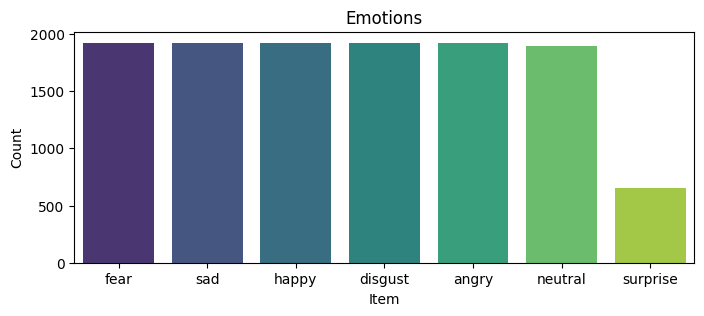

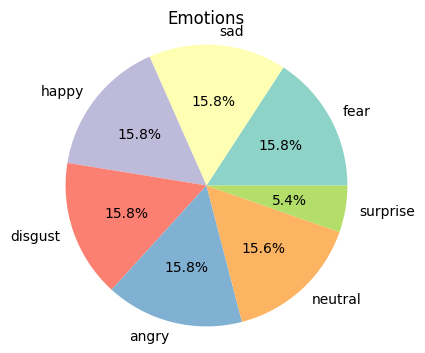

In [17]:
data = df['Emotion']

item_counts = data.value_counts().reset_index()
item_counts.columns = ['Emotion', 'Count']

# bar graph
plt.figure(figsize=(8, 3))
sns.barplot(x='Emotion', y='Count', data=item_counts, palette='viridis')
plt.xlabel("Item")
plt.title("Emotions")
plt.show()
print("\n")
# pie chart
plt.figure(figsize=(4, 4))
plt.pie(item_counts['Count'], labels=item_counts['Emotion'], autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.axis('equal')
plt.title("Emotions")
plt.show()

## Waveforms

Waveforms are graphical representations of how a signal varies with time. They are fundamental in various fields such as physics, engineering, audio processing, and neuroscience. Here’s a detailed explanation of what waveforms are and their significance:

Definition and Basic Concepts
Waveform Definition:

A waveform depicts the variation of a quantity (such as voltage, current, sound pressure, or displacement) as a function of time.
It is typically represented on a two-dimensional graph where the x-axis represents time, and the y-axis represents the amplitude of the signal.
Amplitude:

The amplitude of a waveform is the height of the wave, indicating the strength or intensity of the signal at any given point in time.
Frequency:

Frequency is the number of times the waveform repeats itself within a specific time period (usually one second), measured in Hertz (Hz).
Period:

The period is the duration of one complete cycle of the waveform, which is the inverse of the frequency.
Phase:

Phase refers to the position of a point in time on the waveform cycle, usually measured in degrees or radians.
Wavelength:

Wavelength is the distance between successive corresponding points of the waveform (such as peak to peak or trough to trough) in space.


## Mel Spectrogram
**Definition**
A mel spectrogram is a type of spectrogram that represents the power spectral density of a sound signal on the mel scale, which is a perceptual scale of pitches judged by listeners to be equal in distance from one another.

**Characteristics**
Time-Frequency Representation: Shows how the spectral content of a signal varies over time.
Mel Scale: The frequency axis is converted to the mel scale to better align with human perception of pitch.
Intensity: The color or brightness in the spectrogram indicates the intensity of the frequencies at a given time.
Calculation
Short-Time Fourier Transform (STFT): Computes the Fourier transform of short overlapping windows of the audio signal to obtain the spectrogram.
Mel Filter Bank: Applies a filter bank that maps the frequency bins of the spectrogram to the mel scale.
Logarithm: Often, the logarithm of the mel spectrogram values is taken to compress the dynamic range.

## Mel-Frequency Cepstral Coefficients (MFCCs)
**Definition**
MFCCs are coefficients that collectively make up an MFC (mel-frequency cepstrum), which represents the short-term power spectrum of a sound signal on the mel scale.

**Characteristics**
Compact Representation: Provides a compact and comprehensive representation of the spectral properties of a signal.
Cepstral Domain: Derived from the inverse Fourier transform of the logarithm of the estimated signal spectrum.
Static and Dynamic Features: Can include both static coefficients and their first and second derivatives (delta and delta-delta coefficients).

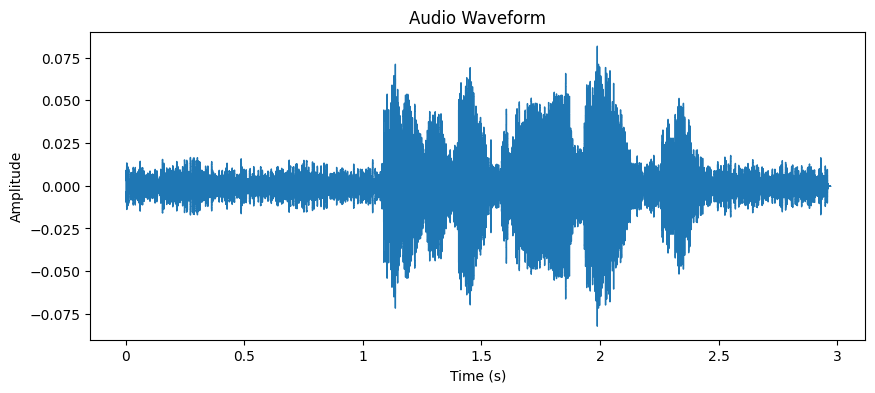

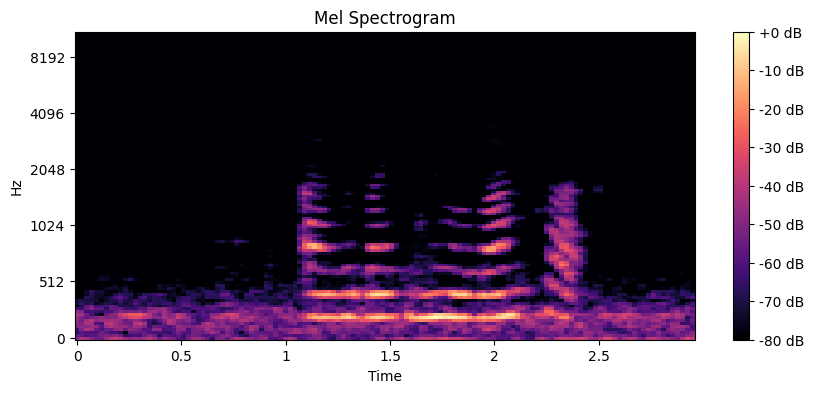

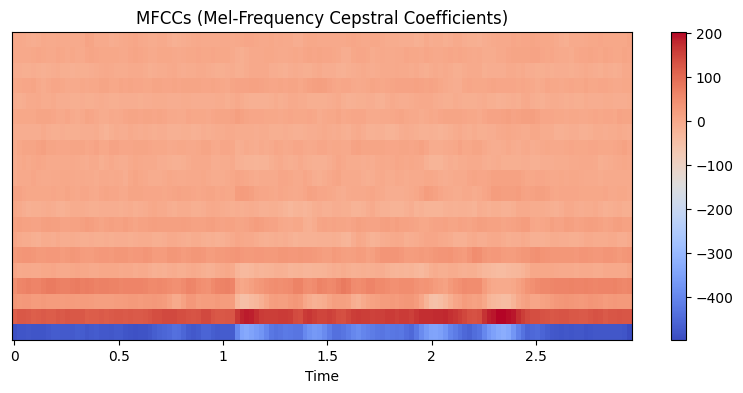

In [18]:
y, sr = librosa.load(df['Path'].iloc[0])

plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Audio Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

S = librosa.feature.melspectrogram(y=y, sr=sr)
S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")
plt.show()

# Extract audio features using MFCC
mfccs = librosa.feature.mfcc(y=y, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title("MFCCs (Mel-Frequency Cepstral Coefficients)")
plt.show()

In [19]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def analyze_audio(file, emotion):
    y, sr = librosa.load(file)

    # waveform
    plt.figure(figsize=(6, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Audio Waveform - "+ emotion)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    print()

    #Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure(figsize=(6, 3))
    librosa.display.specshow(S_db, x_axis='time', y_axis='mel')
    plt.title("Mel Spectrogram - "+ emotion)
    plt.show()
    print()

    # Extract audio features using MFCC
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    plt.figure(figsize=(6, 3))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.title("MFCCs - "+ emotion)
    plt.show()

def analyze_audio_by_emotion(df, emotion):
    print(emotion)
    audio_file = df[df['Emotion'] == emotion].iloc[0]['Path']
    analyze_audio(audio_file, emotion)


fear


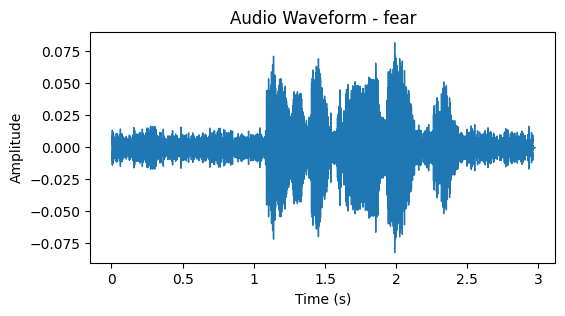

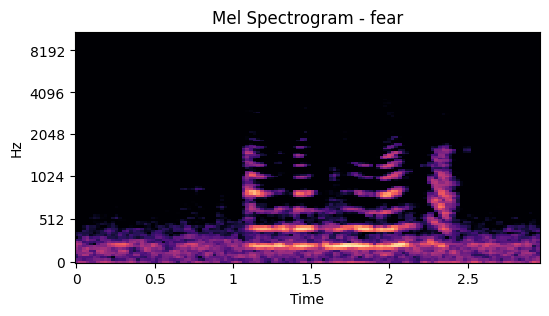

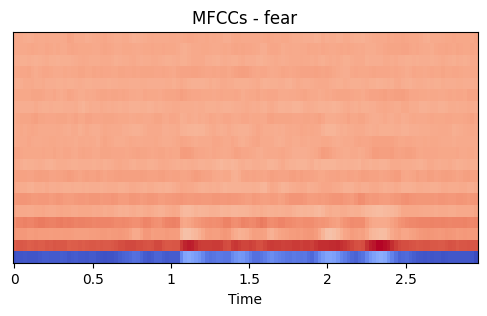

sad


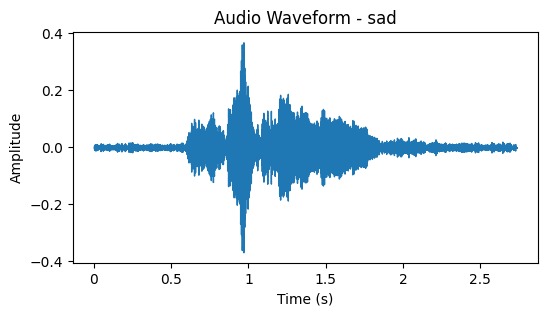

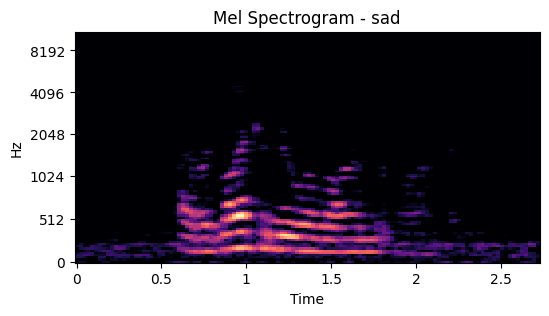

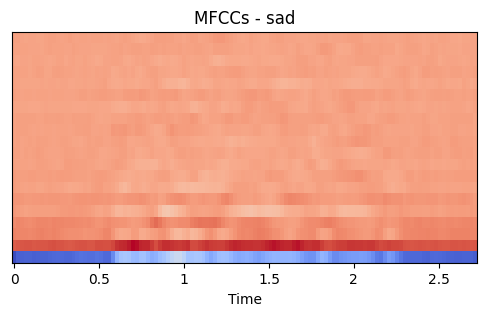

happy


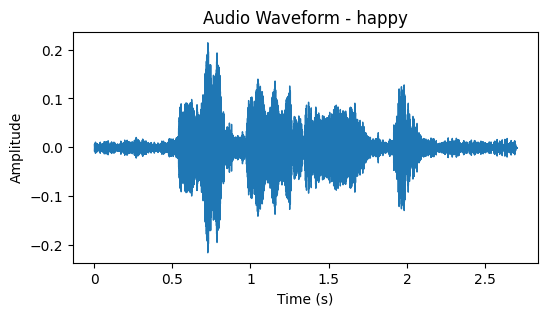

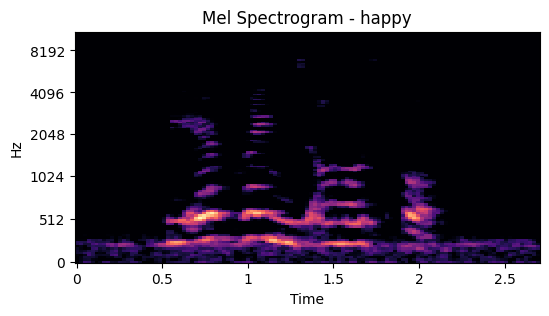

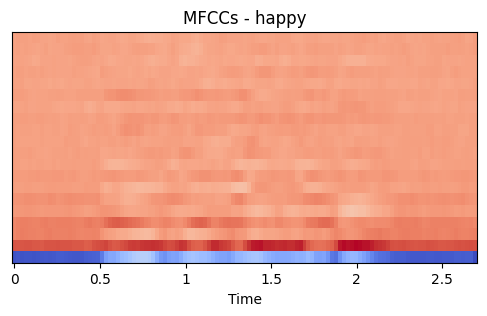

disgust


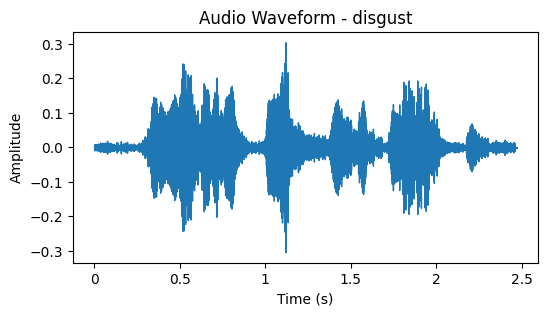

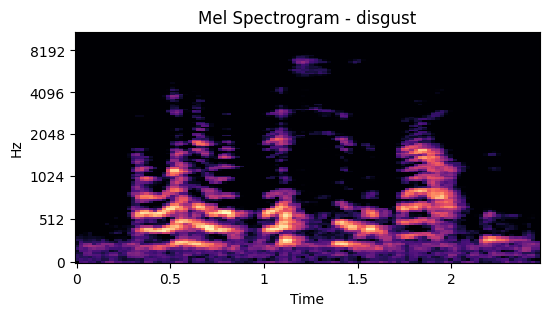

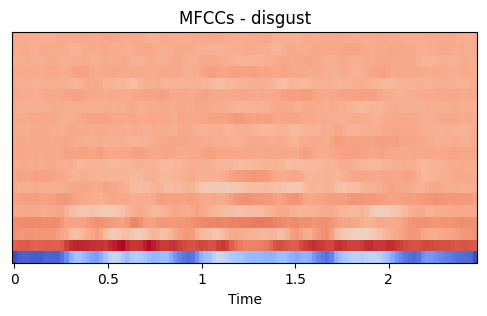

angry


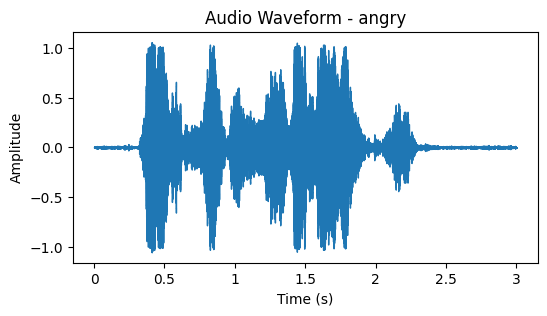

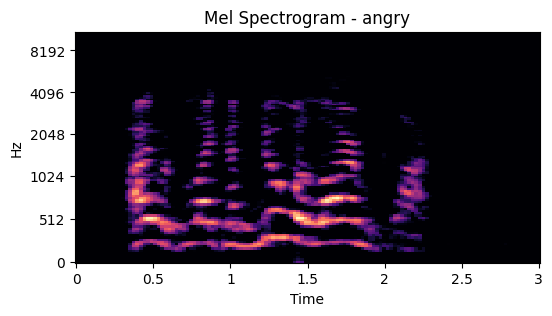

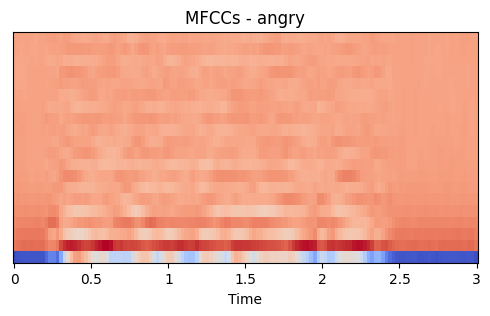

neutral


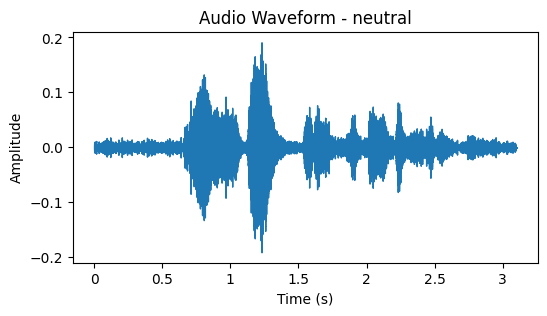

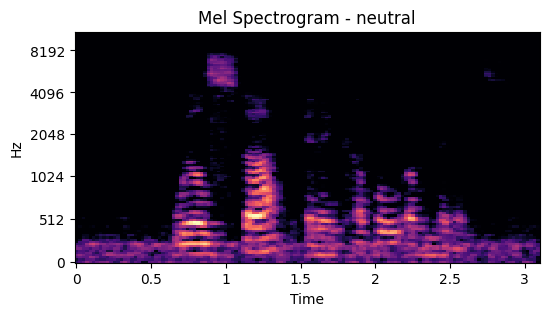

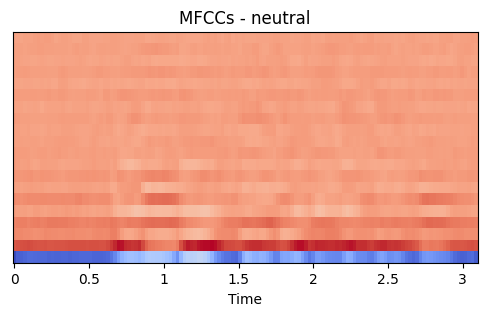

surprise


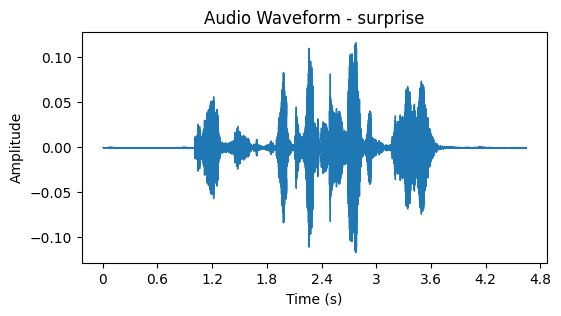

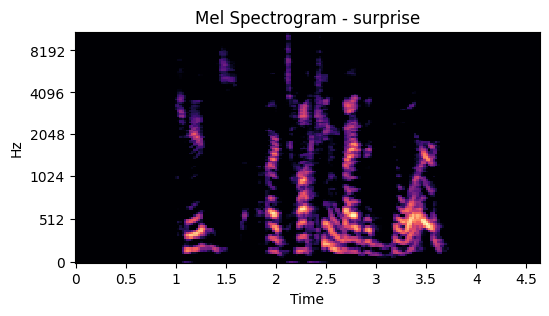

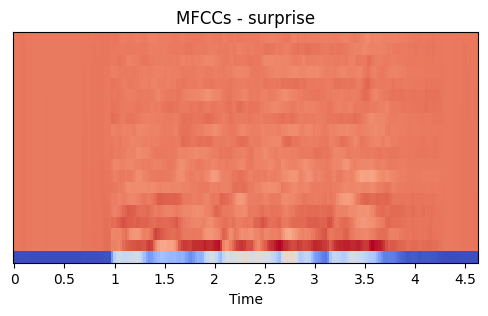

In [20]:
unique_emotions = df['Emotion'].unique()
for emotion in unique_emotions:
    analyze_audio_by_emotion(df, emotion)

In [21]:
audio_arrays = []

for i in df['Path']:
    x, sr = librosa.load(i, sr=44100)
    audio_arrays.append(x)

df['Arrays'] = audio_arrays

# Audio Augmentation

Explanation of Audio Augmentation Techniques
Audio augmentation techniques are used to artificially increase the size and diversity of a dataset by applying various transformations to the audio signals. These techniques help improve the robustness and generalization of machine learning models. Below are the explanations for each of the provided augmentation functions:

1. Adding White Noise

White Noise: This function adds white noise to the original signal. White noise is a random signal having equal intensity at different frequencies, giving it a constant power spectral density.
Implementation:

Purpose: Adding white noise can make the model more robust to variations in the data and helps prevent overfitting by simulating a real-world scenario where recordings might have background noise.


2. Time Stretching

Time Stretching: This technique changes the speed of the audio without affecting its pitch.

Purpose: Time stretching helps the model learn to recognize features regardless of the speed of speech or music. It simulates variations in speaking or playing speed.


3. Pitch Scaling

Pitch Shifting: This technique changes the pitch of the audio without affecting its duration.

Purpose: Pitch scaling allows the model to learn to recognize features regardless of variations in pitch, which is useful in music and speech applications where pitch can vary naturally.


4. Random Gain

Random Gain: This technique randomly changes the volume of the audio signal.

Implementation:
Generate a random gain rate using random.uniform within the specified range (min_factor to max_factor).
Multiply the original signal by this gain rate.

Purpose: Applying random gain helps the model become invariant to volume changes, making it more robust to different recording conditions and speaker volumes.


5. Invert Polarity

Polarity Inversion: This technique flips the audio signal upside down.

Implementation:
Simply multiply the signal by -1.

Purpose: Inverting polarity is a simple yet effective way to augment audio data. It does not affect the perceived sound but changes the waveform, helping the model become robust to polarity inversion which might occur in some recording setups.


These audio augmentation techniques are valuable for enhancing the robustness and generalization capabilities of machine learning models by artificially increasing the diversity of the training data. They simulate various real-world variations and distortions, making the models more adaptable and effective in different scenarios.

In [22]:
def add_white_noise(signal, noise_percentage_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_percentage_factor
    return augmented_signal

def time_stretch_data(data):
    return librosa.effects.time_stretch(data,rate=0.5)

def pitch_scale(signal, sr, num_semitones):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=num_semitones)

def random_gain(signal, min_factor=0.1, max_factor=0.12):
    gain_rate = random.uniform(min_factor, max_factor)
    augmented_signal = signal * gain_rate
    return augmented_signal

def invert_polarity(signal):
    return signal * -1

In [23]:
# def plot_signals(y, augmented_signal, sr):
#     fig, ax = plt.subplots(nrows=2)
#     librosa.display.waveshow(y, sr=sr, ax=ax[0])
#     ax[0].set(title="Original signal")
#     librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
#     ax[1].set(title="Augmented signal")
#     plt.show()

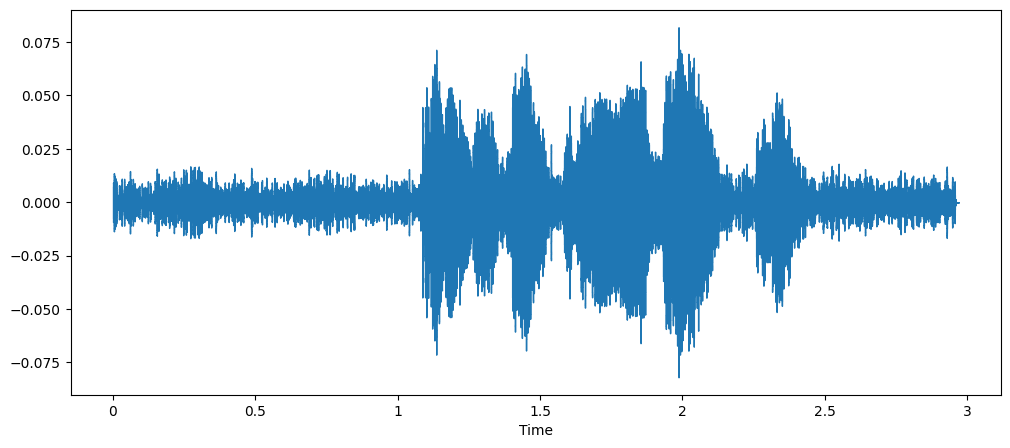

In [24]:
y, sr = librosa.load(df['Path'].iloc[0])

plt.figure(figsize=(12,5))
librosa.display.waveshow(y, sr=sr)

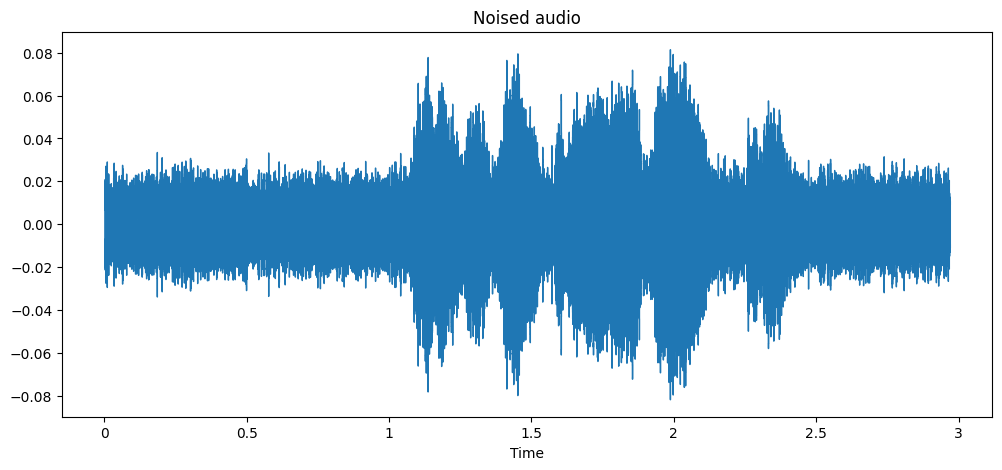

In [25]:
noised_audio=add_white_noise(y,0.5)
plt.figure(figsize=(12,5))
plt.title("Noised audio")
librosa.display.waveshow(noised_audio,sr=sr)
IPython.display.Audio(noised_audio,rate=sr)

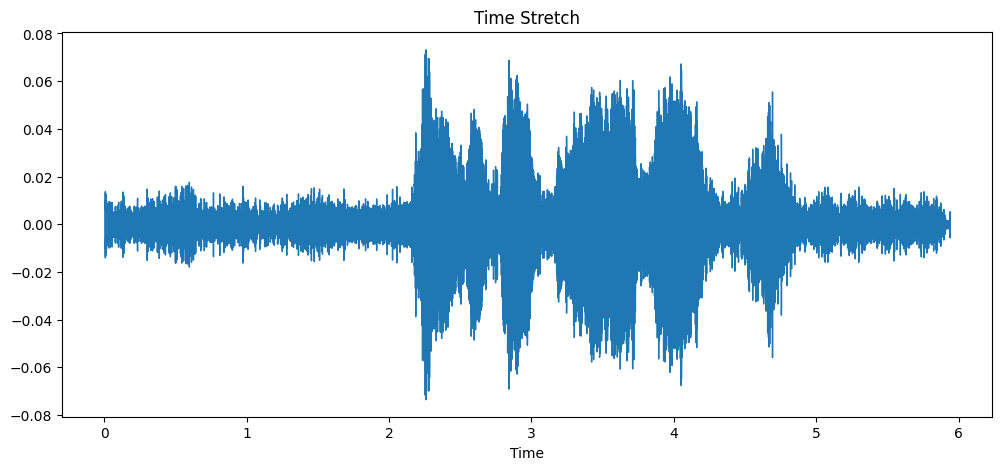

In [26]:
time_stretch_audio=time_stretch_data(y)
plt.figure(figsize=(12,5))
plt.title("Time Stretch")
librosa.display.waveshow(time_stretch_audio,sr=sr)
IPython.display.Audio(time_stretch_audio,rate=sr)

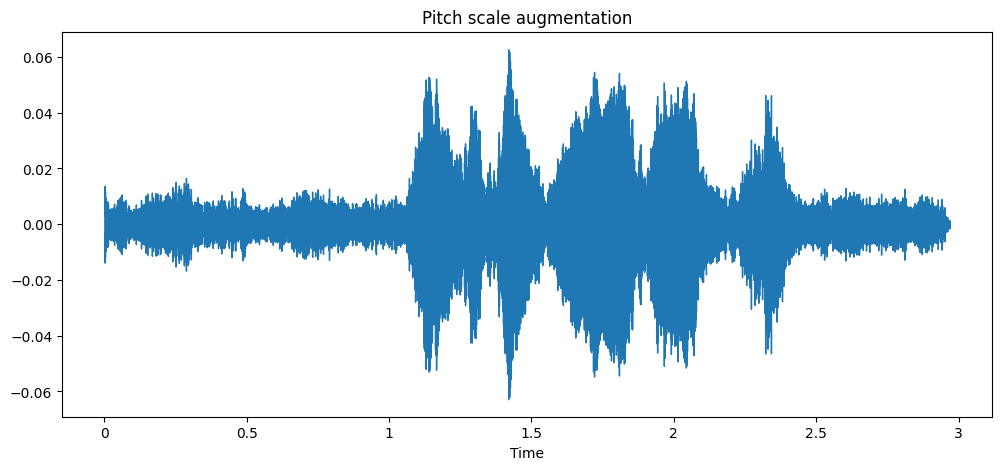

In [27]:
pitch_scale_audio=pitch_scale(y, sr, 24)
plt.figure(figsize=(12,5))
plt.title("Pitch scale augmentation")
librosa.display.waveshow(pitch_scale_audio,sr=sr)
IPython.display.Audio(pitch_scale_audio,rate=sr)

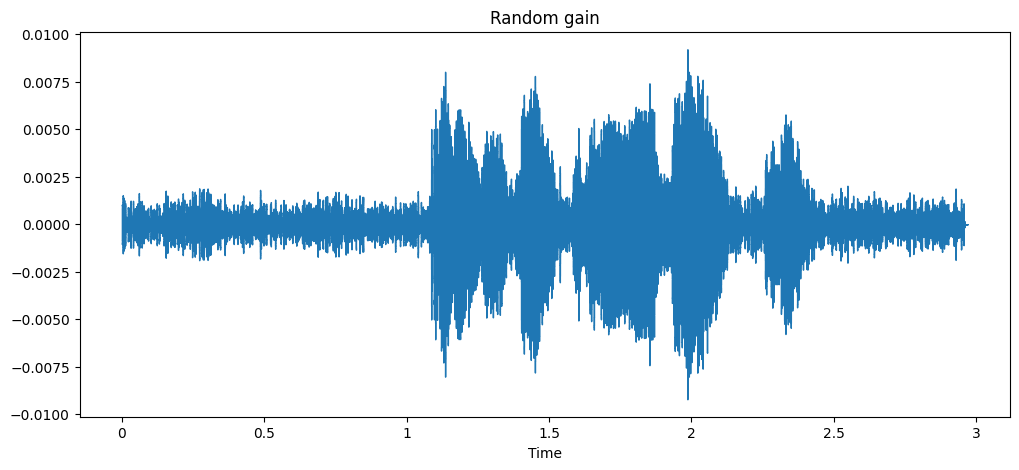

In [28]:
random_gain_audio=random_gain(y)
plt.figure(figsize=(12,5))
plt.title("Random gain")
librosa.display.waveshow(random_gain_audio,sr=sr)
IPython.display.Audio(random_gain_audio,rate=sr)

# Feature Extraction

**Zero Crossing Rate (ZCR)**

Description: Measures how often the signal crosses the horizontal axis.
Usage: Indicates the noisiness of the signal.

**Chroma STFT**

Description: Represents the 12 different pitch classes (Chroma) over time.
Usage: Useful for identifying harmony and chords in music.

**MFCC (Mel-Frequency Cepstral Coefficients)**

Description: Represents the short-term power spectrum of sound.
Usage: Commonly used in speech and audio processing, captures timbral texture.

**Mel Spectrogram**

Description: Spectrogram mapped to the Mel scale (perceived pitch).
Usage: Captures frequency content over time, important for audio classification.

**Tonnetz (Tonnetz Features)**

Description: Represents tonal properties of music.
Usage: Useful for analyzing harmony and tonality.


In [29]:
def extract_features(data):
    # Zero Crossing Rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mfcc))

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr, n_fft=200).T, axis=0)
    result = np.hstack((result, mel))

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sr).T, axis=0);
    result = np.hstack((result, tonnetz));

    return result

In [30]:
def get_features(data):
    result = []

    # without augmentation
    res1 = extract_features(data)
    result.append(res1)

    # with noise
    noise_data = add_white_noise(data, noise_percentage_factor=0.1)
    res2 = extract_features(noise_data)
    result.append(res2)

    # with stretching and pitching
    stretched_data = time_stretch_data(data)
    pitch_shifted_data = pitch_scale(stretched_data, sr, num_semitones=2)
    res3 = extract_features(pitch_shifted_data)
    result.append(res3)

    # with random gain
    gain_data = random_gain(data)
    res4 = extract_features(gain_data)
    result.append(res4)

    return result

In [31]:
warnings.filterwarnings('ignore')

x = []
y = []
for i in tqdm(range(len(df))):
    feature=get_features(df['Arrays'].iloc[i]);
    for j in feature:
        x.append(j)
        y.append(df['Emotion'].iloc[i])

100%|██████████| 12162/12162 [4:07:57<00:00,  1.22s/it]


In [32]:
# x_array = np.array(x)
# y_array = np.array(y)

# x_path = '/content/drive/MyDrive/Projects/Audio Emotion Detection/x_features.npy'
# y_path = '/content/drive/MyDrive/Projects/Audio Emotion Detection/y_emotions.npy'

# # Save arrays to .npy files
# np.save(x_path, x_array)
# np.save(y_path, y_array)

The numpy arrays have been saved to the local directory for re-usability

In [50]:
x_array = np.load('/content/drive/MyDrive/Projects/Audio Emotion Detection/x_features.npy')
y_array = np.load('/content/drive/MyDrive/Projects/Audio Emotion Detection/y_emotions.npy')

le = LabelEncoder()

# Transform labels to numerical values
y_encoded = le.fit_transform(y_array)

# Convert numerical labels to one-hot encoded vectors
y_extracted = to_categorical(y_encoded)
y_extracted

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# Splitting and modeling

In [51]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x_array), np.array(y_extracted), test_size=0.1)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((43783, 167), (43783, 7), (4865, 167), (4865, 7))


In [38]:
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

In [39]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(43783, 167, 1) (43783,) (4865, 167, 1) (4865,)


In [ ]:
model = Sequential()
model.add(Conv1D(128, 3, activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D((1)))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(512, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Conv1D(1024, 3, activation='relu'))
model.add(MaxPooling1D((1)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 165, 128)          512       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 165, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_9 (Conv1D)           (None, 163, 256)          98560     
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 163, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_10 (Conv1D)          (None, 161, 512)          393728    
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 161, 512)         

#CNN

In [ ]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test))

Epoch 1/50
343/343 [==============================] - 755s 2s/step - loss: 2.1589 - accuracy: 0.2706 - val_loss: 1.6163 - val_accuracy: 0.3538
Epoch 2/50
343/343 [==============================] - 747s 2s/step - loss: 1.4457 - accuracy: 0.4149 - val_loss: 1.3398 - val_accuracy: 0.4532
Epoch 3/50
343/343 [==============================] - 751s 2s/step - loss: 1.2963 - accuracy: 0.4745 - val_loss: 1.2519 - val_accuracy: 0.4997
Epoch 4/50
343/343 [==============================] - 751s 2s/step - loss: 1.2373 - accuracy: 0.4971 - val_loss: 1.2713 - val_accuracy: 0.4904
Epoch 5/50
343/343 [==============================] - 751s 2s/step - loss: 1.2039 - accuracy: 0.5170 - val_loss: 1.1766 - val_accuracy: 0.5248
Epoch 6/50
343/343 [==============================] - 751s 2s/step - loss: 1.1742 - accuracy: 0.5292 - val_loss: 1.1671 - val_accuracy: 0.5297
Epoch 7/50
343/343 [==============================] - 751s 2s/step - loss: 1.1510 - accuracy: 0.5394 - val_loss: 1.3801 - val_accuracy: 0.4886

CNN is not giving a good result. So We are going to explore some pre-trained models and feature extraction methods on audio data.

In [ ]:
y_pred = model.predict(x_test)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness','surprise'], yticklabels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])

# XGBoost

In [52]:
!pip install xgboost

In [53]:
from xgboost import XGBClassifier

x_train, x_test, y_train, y_test = train_test_split(np.array(x_array), np.array(y_extracted), test_size=0.1)


In [54]:
model = XGBClassifier()

# Train the classifier
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [56]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.44994861253854057


# VGGish

We are using a pre-trained model for feature extraction.
VGGish is specifically designed for audio data. It is a neural network model developed by Google's AI research team for the purpose of extracting rich audio features from raw audio waveforms. These features can then be used for various audio-related tasks such as sound event detection, environmental sound classification, and speech emotion recognition.

VGGish is particularly well-suited for audio data because it was trained on a large-scale dataset of audio recordings spanning various types of sounds and environments. During training, VGGish learns to extract meaningful representations from the raw audio signals, capturing important characteristics such as spectral content, temporal dynamics, and tonal structure.

In [46]:
def extract_features(audio_path, max_length=1000):
    # Load the audio file
    audio, sr = librosa.load(audio_path, sr=16000)

    # Extract features using VGGish
    features = vggish_model(audio)

    # Pad or truncate features to a fixed length
    if features.shape[0] < max_length:
        features = np.pad(features, ((0, max_length - features.shape[0]), (0, 0)))
    elif features.shape[0] > max_length:
        features = features[:max_length, :]

    return features.flatten()

# Extract features for all audio files with progress bar
features_list = []
for path in tqdm(paths, desc='Extracting Features'):
    features_list.append(extract_features(path))
features = np.array(features_list)


Extracting Features: 100%|██████████| 12162/12162 [07:52<00:00, 25.76it/s]


In [47]:
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# Convert numerical labels to one-hot encoded vectors
y = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)


In [49]:
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the classifier
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
305/305 [==============================] - 88s 285ms/step - loss: 1.4498 - accuracy: 0.4287 - val_loss: 1.2388 - val_accuracy: 0.5068
Epoch 2/20
305/305 [==============================] - 63s 207ms/step - loss: 1.2122 - accuracy: 0.5291 - val_loss: 1.1522 - val_accuracy: 0.5479
Epoch 3/20
305/305 [==============================] - 61s 200ms/step - loss: 1.1414 - accuracy: 0.5457 - val_loss: 1.1185 - val_accuracy: 0.5540
Epoch 4/20
305/305 [==============================] - 62s 205ms/step - loss: 1.0953 - accuracy: 0.5734 - val_loss: 1.1217 - val_accuracy: 0.5557
Epoch 5/20
305/305 [==============================] - 63s 208ms/step - loss: 1.0553 - accuracy: 0.5872 - val_loss: 1.0841 - val_accuracy: 0.5684
Epoch 6/20
305/305 [==============================] - 62s 202ms/step - loss: 1.0431 - accuracy: 0.5907 - val_loss: 1.0876 - val_accuracy: 0.5688
Epoch 7/20
305/305 [==============================] - 62s 204ms/step - loss: 1.0237 - accuracy: 0.5960 - val_loss: 1.0695 - val_ac

# OpenL3

OpenL3 is an open-source deep audio embedding model developed by the MIT-IBM Watson AI Lab. It provides a way to extract deep audio embeddings, which are high-level feature representations of audio signals, using deep neural networks.


In [58]:
!pip install openl3

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openl3: filename=openl3-0.4.2-py2.py3-none-any.whl size=249327032 sha256=1ae1d0c3c254a49574ab8b6329ffef0c06396a7b1c27ea12e30dbe16129a157d
  Stored in directory: /root/.cache/pip/wheels/d0/4d/0a/e57b1dc8ead91b3c5709d9de4f02d1cdd3a91f609a8f1c1062
  Created wheel for kapre: filename=kapre-0.3.7-py3-none-any.whl size=29602 sha256=9fedb32805997a42bb8a8613c52eb7d7562480f29ec214c64580e0deab8de830
  Stored in directory: /root/.cache/pip/wheels/3e/54/f9/37e9f36590a5431dc207f7dc0eb2e607ff8958d5728e45ef58
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320708 sha256=fee9d7715cad80e627a73953681a4dd0d8d2abb434ad73fe1b436d19143ddb79
  Stored in directory: /root

In [ ]:
import openl3
import soundfile as sf
from sklearn.linear_model import LogisticRegression


features = []
labels = []
for index, row in tqdm(df.iterrows(), total=len(df), desc='Processing Audio Files'):
    path = row["Path"]
    emotion = row["Emotion"]

    # Load audio file
    audio, sr = sf.read(path)

    # Extract audio embeddings using OpenL3
    embedding, _ = openl3.get_audio_embedding(audio, sr, verbose=False)

    # Store features and labels
    features.append(embedding)
    labels.append(emotion)

# Convert lists to numpy arrays
features = np.array(features)
labels = np.array(labels)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Reshape features for training (OpenL3 embeddings are 6144-dimensional)
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Initialize and train a logistic regression classifier
clf = LogisticRegression()
clf.fit(x_train_flat, y_train)

y_pred = clf.predict(x_test_flat)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Processing Audio Files:   0%|          | 36/12162 [02:06<11:14:13,  3.34s/it]